In [1]:
# Recreating Terence Shin's machine Learning project on 
# https://towardsdatascience.com/a-machine-learning-project-predicting-used-car-prices-efbc4d2a4998

# Import libraries and data
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_67f476715e2f4a92b07bba55beba4ee6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_67f476715e2f4a92b07bba55beba4ee6.get_object(Bucket='predictingusedcarprices-donotdelete-pr-nv62jzsi2ydncp',Key='vehicles.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df = pd.read_csv(body)

In [2]:
print(df.shape) # see number of rows and columns in data frame
df.dtypes # see data types of columns in data frame
df.head()
df.nunique(axis=0) # return the number of unique values in each column
df.describe() # return stats about numerical columns
df.describe().apply(lambda s: s.apply(lambda x: format(x,'f'))) # return stats as floats
# without scientific notation 
df.columns # see columns in data frame

(458213, 26)


Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year',
       'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'image_url', 'description', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [30]:
# 'df.isna().sum()' returns the total # of nas per df column
# This is useful for quickly identifying the columns with a high count of NAs relative to the df size
# One way to clean a dataframe is to delete the columns with too many null values,
# but, i think a column with too many NAs may still be a useful predictor of the dependent variable
# If I were going to delete columns with too many NAs, I will do so as specified in this cell
# Is null = NA? In Python Pandas, yes!
"""""
delcol = [] # append columns exceeding NA threshold to this list
thresh = 0.4 
# return Pandas series with df columns as keys and T/F values if column NA count > threshold
dfthreshreached = df.isna().sum() > thresh*df.shape[0]
for i in dfthreshreached.keys():
    if dfthreshreached[i] == True:
        delcol.append(i)
print(delcol) # In this case, the columns returned [condition, VIN and size] I think are useful predictive variables
# So create a separate df that we can work with if we wanted to come back to this approach
delcoldf = df.drop(columns = delcol)
print(delcoldf.shape)
"""""

'""\ndelcol = [] # append columns exceeding NA threshold to this list\nthresh = 0.4 \n# return Pandas series with df columns as keys and T/F values if column NA count > threshold\ndfthreshreached = df.isna().sum() > thresh*df.shape[0]\nfor i in dfthreshreached.keys():\n    if dfthreshreached[i] == True:\n        delcol.append(i)\nprint(delcol) # In this case, the columns returned [condition, VIN and size] I think are useful predictive variables\n# So create a separate df that we can work with if we wanted to come back to this approach\ndelcoldf = df.drop(columns = delcol)\nprint(delcoldf.shape)\n'

In [ ]:
# Let's actually delete columns that we think we can do without.
# We can suspect ['Unnamed: 0', 'id', 'url', 'region_url', 'image_url', 'lat', 'long', 'posting_date', 'state','title_status']
# Let's visualize variable relationships to confirm the suspicion
import matplotlib.pyplot as plt
import numpy as np

# Draw correlation matrix plot
correlations = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0,26,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()
# That was a semi-failure

# Try much easier scatterplot matrix
from pandas.plotting import scatter_matrix
scatter_matrix(df)

# Kind of a failure too

# In both cases, no more than 7 x 7 sub plots

In [3]:
# Drop desired rows still. drop function does not impact original dataframe if not reassigned
df = df.drop(columns = ['Unnamed: 0', 'id', 'url', 'region_url', 'image_url','posting_date', 'lat','long','title_status'])
df = df.drop(columns = ['region','VIN'])
df = df.drop(columns = ['description']) # the author says natural language processing is beyond scope of model
print(df.shape)
print(df.columns)

(458213, 14)
Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'state'],
      dtype='object')


               price           year       odometer
count  387287.000000  386582.000000  387287.000000
mean    14120.433492    2011.301527   92627.935028
std     11259.529434       7.609179   59059.088743
min         0.000000    1900.000000       0.000000
25%      5000.000000    2008.000000   42149.000000
50%     11495.000000    2013.000000   88920.000000
75%     20990.000000    2016.000000  134000.000000
max     46350.000000    2021.000000  271420.000000


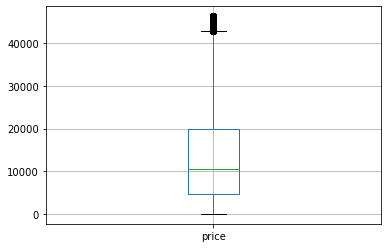

In [4]:
# Delete rows with unrealistic ranges (set reasonable min and max)
# First remove price outliers
df = df[df['price'].between(0,300000)]
df.shape # Only 64 rows were deleted
# Compute IQR
Q1price = df['price'].quantile(0.25)
Q3price = df['price'].quantile(0.75)
IQRprice = Q3price - Q1price
# Remove outliers defined by values < Q1price - 1.5*IQRprice and > Q3price + 1.5*IQRprice
df = df[df['price'].between(Q1price - 1.5*IQRprice,Q3price + 1.5*IQRprice)]
df.shape # additional 12,750 rows have been deleted
df.boxplot('price')

# Second, remove unrealistic odometer values
df = df[df['odometer'].between(0,271431.5)]
print(df.describe()) # Current max car price is 46,350. Max odometer is 271420

In [ ]:
# Visualize remaining variables and relationships
import matplotlib.pylab as plt
import seaborn as sns

corr = df.corr() # calculate correlation matrix
# plot the heatmap
sns.heatmap(corr,xticklabels = corr.columns,yticklabels = corr.columns, annot = True,
           cmap = sns.diverging_palette(220,20,as_cmap = True))

In [ ]:
# Plot some individual categorical attributes
df['manufacturer'].value_counts().plot(kind ='bar')
df['type'].value_counts().plot(kind = 'bar')
df['paint_color'].value_counts().plot(kind = 'bar')

In [11]:
# Now, onto the data modelling

#df = pd.get_dummies(df,drop_first=True)

# running line directly above always crashes the kernel, which I suspect is due to the model variable
# I'll drop model variable before I get dummies again. 'model' column had 35900 unique values
# this totally worked

df = df.drop(columns = ['model']) 
df = df.dropna(axis = 0, how ='any', thresh = None) # Is it this specific line that changes the df object type to a 'NoneType' object type 
# when inplace = True is given as input?
# Specific line above was added later when fitting model to training values caused error due to Nan values
df.count
df.columns
df.nunique(axis=0)
df = pd.get_dummies(df,drop_first=True)
df.columns

Index(['price', 'year', 'odometer', 'manufacturer_alfa-romeo',
       'manufacturer_aston-martin', 'manufacturer_audi', 'manufacturer_bmw',
       'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt',
       'state_wa', 'state_wi', 'state_wv', 'state_wy'],
      dtype='object', length=139)

In [12]:
# Scaling the data. Why?
from sklearn.preprocessing import StandardScaler

y = df['price']
X = df.drop('price',axis = 1)
X = StandardScaler().fit_transform(X)

In [13]:
# Create the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 0)
model = RandomForestRegressor(random_state = 0)
model.fit(X_train, y_train)
print(mae(y_train,model.predict(X_train)))
print(mae(y_test, model.predict(X_test)))

848.4730713151757
2225.147706363594


In [17]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9721057879024253
0.8085905273716159


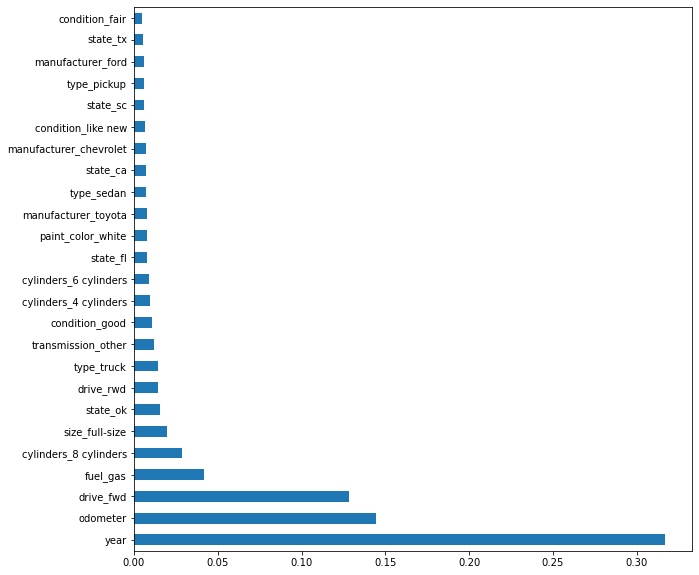

In [28]:
# Feature Importance
X_head = df.iloc[:,df.columns != 'price']
feat_importance = pd.Series(model.feature_importances_, index = X_head.columns)
feat_importance.nlargest(25).plot(kind = 'barh',figsize=(10,10))

In [ ]:
# Model done. I have so many questions.
# The accuracy of my model was 10% less than the author's
# My model did not work with Nan values in the dataset, but seemed to work for the author